In [32]:
import os
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point


In [29]:
folder = "/Users/One/Documents/JAXA/v201_nc4_normal_std_monthly/"
for x in os.listdir(folder):
    test = xr.open_dataset(folder+x)
    break

In [30]:
test

<xarray.Dataset>
Dimensions:                  (lat: 6001, lon: 6001)
Coordinates:
  * lat                      (lat) float32 60.0 59.98 59.96 ... -59.98 -60.0
  * lon                      (lon) float32 80.0 80.02 80.04 ... -160.0 -160.0
Data variables:
    sea_surface_temperature  (lat, lon) float32 ...
Attributes:
    processing_level:           L3C
    cdm_data_type:              grid
    spatial_resolution:         0.02 deg
    geospatial_lat_units:       degrees north
    geospatial_lat_resolution:  0.02
    geospatial_lon_units:       degrees east
    geospatial_lon_resolution:  0.02

In [18]:
def palau_eez(df):
    df_eez = gpd.read_file('./palauEEZ.geojson')
    eez = df_eez['geometry'].values[0]
    in_palau = []
    longlat = df[['lon','lat']].values.tolist()
    for x in longlat:
        point = Point(x[0],x[1])
        if eez.contains(point) or point.within(eez):
            in_palau.append((x[0],x[1]))
    return df[df[['lon', 'lat']].apply(tuple, axis=1).isin(in_palau)]

In [39]:
from sklearn.neighbors import NearestNeighbors
from geopandas import GeoDataFrame
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.ops import cascaded_union
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import json

In [53]:
from shapely import geometry
p1 = geometry.Point(129.5088 -0.1,1.6214-0.25)
p2 = geometry.Point(136.9541 + 0.1, 1.6214-0.25)
p3 = geometry.Point(136.9541+0.1,11.5587+0.1)
p4 = geometry.Point(129.5088-0.1,11.5587+0.1)

pointList = [p1, p2, p3, p4, p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

sdf = pd.DataFrame(
    {
        "Country": ["Palau"],
        "geometry": [poly
        ],
    }
)
gdf = gpd.GeoDataFrame(sdf, geometry="geometry")
# boundary = gpd.read_file('palauEEZ.geojson')
boundary = gdf
boundary = boundary.explode()
boundary = boundary.set_crs(crs="EPSG:3395", allow_override=True)
boundary_shape = cascaded_union(boundary.geometry)

df_eez = gpd.read_file('palauEEZ.geojson')
eez = df_eez['geometry'].values[0]

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/3739479884.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  boundary = boundary.explode()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/3739479884.py:22: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  boundary_shape = cascaded_union(boundary.geometry)


In [67]:
def getSSTJSON(df):
#     df = palau_eez(df)
    df_slice = df


    coordinates = df_slice[['lat','lon','sea_surface_temperature']]
    coordinates = coordinates.drop_duplicates()

    colors = ["#990000","#cc0000","#ff0000","#ff3500","#ff6a00","#ff9f00",
         "#ffd400","#f7fb02","#d0ec0d","#aadd19","#83cd25","#5cbe30",
         "#36ae3c","#0f9f47","#098b63","#1a758a","#2b5fb1","#3b49d8",
         "#4c33ff","#8c19ff","#cc00ff"]
    colors.reverse()
    levels = len(colors)
    vmin   = min(df.sea_surface_temperature.tolist())
    vmax   = max(df.sea_surface_temperature.tolist())
    tiers = np.linspace(vmin,vmax,levels+1).tolist()

    
    df_slice = df_slice.sort_values(by=['lon','lat'], ascending=[False,True])
    df_slice['new_col'] = list(zip(df_slice.lat, df_slice.lon))#         coordinates = coordinates.drop_duplicates()
    coordinates = []

    for c in df_slice['new_col']:
        coordinates.append([c[0],c[1]])
    points = []
    for x in coordinates:
        points.append(Point(x[1],x[0]))
        
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=points)
    in_palau = []
    for point in points_gdf.geometry:
        if eez.contains(point) or point.within(eez):
            in_palau.append(point)
    points_gdf = GeoDataFrame(crs="EPSG:3395", geometry=in_palau)
    
    gdf_proj = points_gdf.to_crs(boundary.crs)

    coords = points_to_coords(gdf_proj.geometry)
    poly_shapes, pts = voronoi_regions_from_coords(coords, boundary_shape)
    voronoi_poly = GeoDataFrame(crs="EPSG:3395", geometry=list(poly_shapes.values()))
    
    longitude = []
    latitude = []
    for pt in pts:
        longitude.append(coords[pt][0])
        latitude.append(coords[pt][1])
    voronoi_poly["lon"] = longitude
    voronoi_poly["lat"] = latitude

    
    df_slice = df_slice.drop(['new_col'], axis=1)
    

    df_slice['geometry'] = voronoi_poly.sort_values(by=['lon','lat'], ascending=[False,True])['geometry'].tolist()
    df_slice = df_slice.reset_index()
    df_slice = df_slice.drop('index',axis=1)
    df_slice = df_slice[df_slice['sea_surface_temperature'].notna()]
    values = df_slice['sea_surface_temperature'].tolist()
    
    df_colors = []

    for v in values:
        for i in range(len(tiers)):
            if tiers[i] > v:
                df_colors.append(colors[i-1])
                break
            if tiers[-1] <= v:
                df_colors.append(colors[-1])
                break

    
    df_slice['fill'] = df_colors
    
    voronoi_color = GeoDataFrame(df_slice[['geometry','fill']],crs="EPSG:3395")

    R,G,B = [], [],[]
    for color in df_slice['fill'].tolist():
        r,g,b = [int(str(color[1:])[i:i+2], 16) for i in (0, 2, 4)]
        R.append(r)
        G.append(g)
        B.append(b)
    df_slice['R'] = R
    df_slice['G'] = G
    df_slice['B'] = B
    
    json_gdf = GeoDataFrame(df_slice,crs="EPSG:3395")
    
    palau_land = gpd.read_file('palau.geojson')
    palau_land = palau_land.drop(['type','id','tags','meta'],axis = 1)
    palau_land = palau_land[palau_land.geometry.type != 'LineString']
    trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
    
    
    palau_eez = gpd.read_file('palauEEZ.geojson')
    trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")
    
    
    #Plotting voronoi
    fig, ax = plt.subplots(figsize=(12, 10))
    boundary.plot(ax=ax, color="gray")
    trimmed.plot(ax=ax, color=trimmed["fill"])
#     points_gdf.plot(ax=ax, markersize=1, color="black")
    ax.axis("off")
    plt.axis('equal')
    plt.show()
    
    
    
    
    
    
    
    
    
    return json.loads(json_gdf)

In [16]:
current_df = test.to_dataframe()

In [23]:
current_df.reset_index(inplace= True)

In [31]:
test_df = palau_eez(current_df)

In [64]:
test_df

,lat,lon,sea_surface_temperature
14543136,11.540001,134.259995,29.059998
14543137,11.540001,134.279999,29.070007
14543138,11.540001,134.300003,29.070007
14543139,11.540001,134.320007,29.100006
14543140,11.540001,134.339996,29.079987
...,...,...,...
17513551,1.640003,132.660004,29.989990
17513552,1.640003,132.679993,30.010010
17513553,1.640003,132.699997,30.040009
17513554,1.640003,132.720001,30.019989


In [34]:
test_df['sea_surface_temperature'] = test_df['sea_surface_temperature'] - 273.15

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/1888598755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sea_surface_temperature'] = test_df['sea_surface_temperature'] - 273.15


In [ ]:
test_df[test_df['sea_surface_temperature'].notna()]

In [35]:
test_df

,lat,lon,sea_surface_temperature
14543136,11.540001,134.259995,29.059998
14543137,11.540001,134.279999,29.070007
14543138,11.540001,134.300003,29.070007
14543139,11.540001,134.320007,29.100006
14543140,11.540001,134.339996,29.079987
...,...,...,...
17513551,1.640003,132.660004,29.989990
17513552,1.640003,132.679993,30.010010
17513553,1.640003,132.699997,30.040009
17513554,1.640003,132.720001,30.019989


In [70]:
import pandas as pd

# Example DataFrame

df = test_df

# Calculate differences in longitude within each latitude group
df['lon_diff'] = df.groupby('lat')['lon'].diff()

# Calculate differences in latitude within each longitude group
df['lat_diff'] = df.groupby('lon')['lat'].diff()

# Drop rows with NaN differences (first rows in each group)
df_closest_diffs = df.dropna(subset=['lat_diff', 'lon_diff'])

# Display results
print(df_closest_diffs[['lat', 'lon', 'lat_diff', 'lon_diff']])
lat_spacing = df['lat_diff'].dropna().unique()
lon_spacing = df['lon_diff'].dropna().unique()
print("Unique Latitude Differences:", lat_spacing)
print("Unique Longitude Differences:", lon_spacing)
print("Mean Latitude Difference:", df['lat_diff'].mean())
print("Mean Longitude Difference:", df['lon_diff'].mean())


                lat         lon  lat_diff  lon_diff
14549137  11.520000  134.259995 -0.020000  0.020004
14549138  11.520000  134.279999 -0.020000  0.020004
14549139  11.520000  134.300003 -0.020000  0.020004
14549140  11.520000  134.320007 -0.020000  0.020004
14549141  11.520000  134.339996 -0.020000  0.019989
...             ...         ...       ...       ...
17513551   1.640003  132.660004 -0.019997  0.020004
17513552   1.640003  132.679993 -0.019997  0.019989
17513553   1.640003  132.699997 -0.019997  0.020004
17513554   1.640003  132.720001 -0.019997  0.020004
17513555   1.640003  132.739990 -0.019997  0.019989

[125151 rows x 4 columns]
Unique Latitude Differences: [-0.02000046 -0.01999664 -0.77999878]
Unique Longitude Differences: [0.02000427 0.01998901 0.37998962 0.72000122 1.08000183]
Mean Latitude Difference: -0.02000605635766655
Mean Longitude Difference: 0.020016911395691825


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/804267485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon_diff'] = df.groupby('lat')['lon'].diff()
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/804267485.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat_diff'] = df.groupby('lon')['lat'].diff()


/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/4124544457.py:92: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')


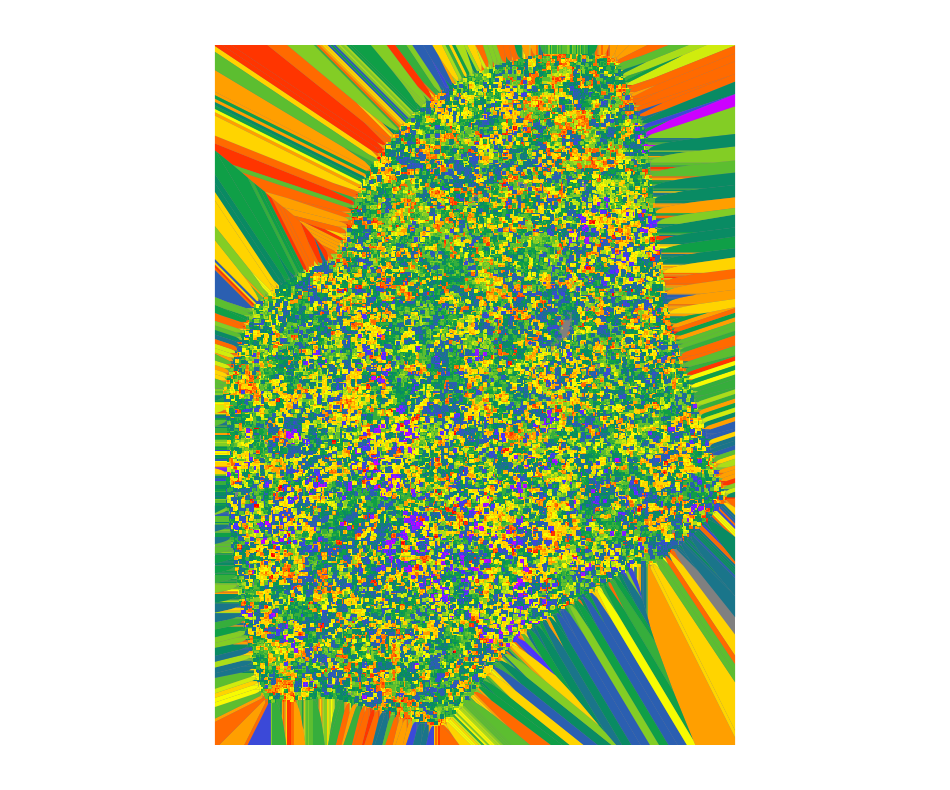

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {'lat': 4.979999542236328,
    'lon': 136.94000244140625,
    'sea_surface_temperature': 29.980010986328125,
    'fill': '#ffd400',
    'R': 255,
    'G': 212,
    'B': 0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[135.24999237060547, 11.489999771118164],
      [135.2699966430664, 11.510007859003947],
      [135.2699966430664, 11.470001220703125],
      [135.24999237060547, 11.470001220703125],
      [135.24999237060547, 11.489999771118164]]]}},
  {'id': '1',
   'type': 'Feature',
   'properties': {'lat': 5.0,
    'lon': 136.94000244140625,
    'sea_surface_temperature': 30.05999755859375,
    'fill': '#ff9f00',
    'R': 255,
    'G': 159,
    'B': 0},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[135.31000518798828, 11.450002670288086],
      [135.29000091552734, 11.450002670288086],
      [135.29000091552734, 11.470001220703125],
      [135.31000518798828, 11.47000

In [66]:
getSSTJSON(test_df)

/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/2314541995.py:92: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(json_gdf,palau_land, how='difference')
/var/folders/d6/w300s4cx3qj10pqdcy5859bc0000gn/T/ipykernel_68080/2314541995.py:96: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3395
Right CRS: EPSG:4326

  trimmed = gpd.overlay(trimmed,palau_eez, how = "intersection")


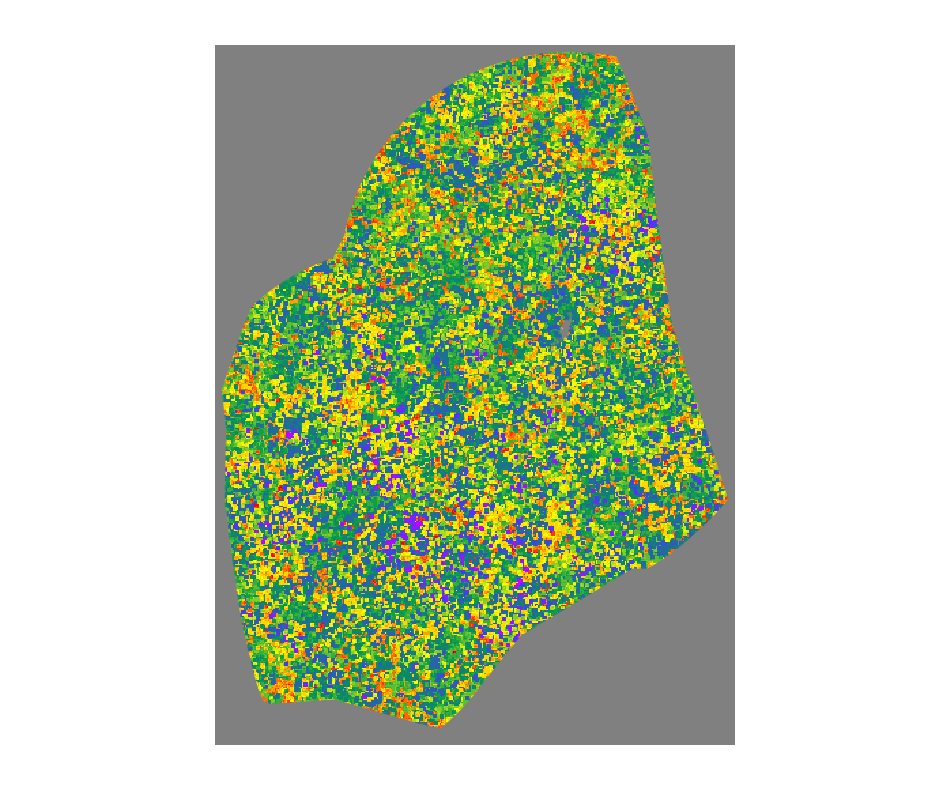

TypeError: the JSON object must be str, bytes or bytearray, not GeoDataFrame

In [68]:
getSSTJSON(test_df)

In [79]:
from PIL import Image

# Load the image
image_path = "colorbar_sst_JAXA.png"
image = Image.open(image_path)

# Convert the image to RGB mode if not already
image = image.convert("RGB")

# Extract all pixels
pixels = list(image.getdata())

# Get unique colors and convert them to hex codes
unique_colors = set(pixels)  # Removes duplicate colors
hex_colors = ['#{:02x}{:02x}{:02x}'.format(r, g, b) for r, g, b in unique_colors]

# Print unique colors in hex format
print("Unique colors in HEX format:")
for color in hex_colors:
    print(color)


Unique colors in HEX format:
#00008b
#0058ff
#000097
#ff0000
#bfff44
#d7ff2c
#efff14
#ff1800
#b3ff50
#0093ff
#ffbf00
#ff3000
#0000ec
#0000af
#83ff80
#00abff
#ff4800
#001cff
#0000f8
#0000bb
#00c3ff
#0000c7
#54ffaf
#8fff74
#00dbff
#e3ff1f
#ffef00
#ffffff
#ff8300
#ff7800
#ff6000
#0000df
#f30000
#9f0000
#0cfff8
#ff9b00
#004cff
#00f3ff
#007cff
#18ffec
#000000
#6cff97
#ffb300
#0087ff
#ff2400
#48ffbb
#78ff8b
#ffcb00
#0010ff
#ff5400
#b70000
#ffe300
#00b7ff
#0028ff
#24ffdf
#3cffc7
#a7ff5c
#cf0000
#c30000
#fffb00
#ff8f00
#e70000
#0040ff
#00e7ff
#0070ff


In [90]:
from PIL import Image
import colorsys

# Load the image
image_path = "colorbar_cropped.jpg"
image = Image.open(image_path)

# Convert the image to RGB mode if not already
image = image.convert("RGB")

# Extract all pixels
pixels = list(image.getdata())

# Get unique colors
unique_colors = set(pixels)  # Removes duplicate colors

# Convert RGB to HEX and sort based on hue
def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(rgb[0], rgb[1], rgb[2])

def sort_by_hue(color):
    r, g, b = color
    # Convert RGB to HSV and return the hue
    h, s, v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)
    return h  # Sort by hue

# Sort unique colors by hue
sorted_colors = sorted(unique_colors, key=sort_by_hue)

# Convert to HEX format
sorted_hex_colors = [rgb_to_hex(color) for color in sorted_colors]

# Print sorted colors in hex format
print("Sorted colors in HEX format (blue -> green -> yellow -> red):")
for color in sorted_hex_colors:
    print(color)


Sorted colors in HEX format (blue -> green -> yellow -> red):
#f40000
#fe0000
#e80000
#b80000
#c30000
#d00000
#a00000
#fe1800
#fe2400
#fe3000
#ff4900
#ff5500
#ff6100
#ff7900
#ff8201
#ff8e01
#ff9a00
#ffb200
#ffbe00
#ffca00
#ffe401
#fff001
#fffc01
#eeff13
#e3ff1f
#d7ff2c
#bfff44
#b2ff4f
#a7ff5b
#8fff74
#82ff7f
#78fe8b
#6cff97
#54ffb0
#48ffbc
#3cffc7
#24ffdf
#18ffeb
#0cfff8
#01f3ff
#01e7ff
#01dbff
#01c3ff
#00b6ff
#00aaff
#0092ff
#0086ff
#007dfe
#0071fe
#0059ff
#004dff
#0041ff
#0128ff
#011cff
#000ffe
#0000ec
#0000f8
#0000df
#000098
#0000b0
#0000bc
#0100c8
#01008c


In [100]:
from PIL import Image
from collections import Counter

# Load the new uploaded image
image_path = "colorbar_cropped.jpg"
image = Image.open(image_path)

# Convert image to RGB mode to ensure consistency
image = image.convert("RGB")

# Resize to focus on horizontal color extraction (reduce vertical noise)
# Take just a small horizontal slice from the middle of the image
width, height = image.size
horizontal_strip = image.crop((0, height // 2, width, height // 2 + 1))

# Extract all pixels from the horizontal strip
pixels = list(horizontal_strip.getdata())

# Count occurrences of each color
color_counts = Counter(pixels)

# Get the 66 most common colors
most_common_colors = [color for color, _ in color_counts.most_common(66)]

# Convert colors to HEX format in their original order (left-to-right)
unique_colors_in_order = []
for pixel in pixels:
    if pixel in most_common_colors and pixel not in unique_colors_in_order:
        unique_colors_in_order.append(pixel)

hex_colors = ['#{:02x}{:02x}{:02x}'.format(r, g, b) for r, g, b in unique_colors_in_order]

# Output the sorted colors
hex_colors


['#01008c',
 '#000098',
 '#0000b0',
 '#0000bc',
 '#0100c8',
 '#0000df',
 '#0000ec',
 '#0000f8',
 '#000ffe',
 '#011cff',
 '#0128ff',
 '#0041ff',
 '#004dff',
 '#0059ff',
 '#0071fe',
 '#007dfe',
 '#0086ff',
 '#0092ff',
 '#00aaff',
 '#00b6ff',
 '#01c3ff',
 '#01dbff',
 '#01e7ff',
 '#01f3ff',
 '#0cfff8',
 '#18ffeb',
 '#24ffdf',
 '#3cffc7',
 '#48ffbc',
 '#54ffb0',
 '#6cff97',
 '#78fe8b',
 '#82ff7f',
 '#8fff74',
 '#a7ff5b',
 '#b2ff4f',
 '#bfff44',
 '#d7ff2c',
 '#e3ff1f',
 '#eeff13',
 '#fffc01',
 '#fff001',
 '#ffe401',
 '#ffca00',
 '#ffbe00',
 '#ffb200',
 '#ff9a00',
 '#ff8e01',
 '#ff8201',
 '#ff7900',
 '#ff6100',
 '#ff5500',
 '#ff4900',
 '#fe3000',
 '#fe2400',
 '#fe1800',
 '#fe0000',
 '#f40000',
 '#e80000',
 '#d00000',
 '#c30000',
 '#b80000',
 '#a00000']

In [101]:
len(hex_colors)

63

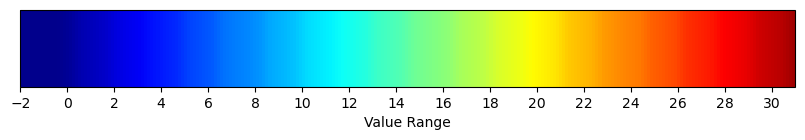

In [115]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

colors = [hex_colors[0]]*3
colors.extend(hex_colors)

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

# Define the normalization
norm = mcolors.Normalize(vmin=-2, vmax=31)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 1))

# Create the color bar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), 
                    cax=ax, orientation='horizontal', ticks=np.arange(-2, 34, 2))

# Add labels to the color bar
cbar.set_label('Value Range')
plt.show()


In [125]:
colors = ['#01008c','#01008c','#01008c','#01008c',
 '#000098',
 '#0000b0',
 '#0000bc',
 '#0100c8',
 '#0000df',
 '#0000ec',
 '#0000f8',
 '#000ffe',
 '#011cff',
 '#0128ff',
 '#0041ff',
 '#004dff',
 '#0059ff',
 '#0071fe',
 '#007dfe',
 '#0086ff',
 '#0092ff',
 '#00aaff',
 '#00b6ff',
 '#01c3ff',
 '#01dbff',
 '#01e7ff',
 '#01f3ff',
 '#0cfff8',
 '#18ffeb',
 '#24ffdf',
 '#3cffc7',
 '#48ffbc',
 '#54ffb0',
 '#6cff97',
 '#78fe8b',
 '#82ff7f',
 '#8fff74',
 '#a7ff5b',
 '#b2ff4f',
 '#bfff44',
 '#d7ff2c',
 '#e3ff1f',
 '#eeff13',
 '#fffc01',
 '#fff001',
 '#ffe401',
 '#ffca00',
 '#ffbe00',
 '#ffb200',
 '#ff9a00',
 '#ff8e01',
 '#ff8201',
 '#ff7900',
 '#ff6100',
 '#ff5500',
 '#ff4900',
 '#fe3000',
 '#fe2400',
 '#fe1800',
 '#fe0000',
 '#f40000',
 '#e80000',
 '#d00000',
 '#c30000',
 '#b80000',
 '#a00000']

color_dict = {}
xs = (x * 0.5 for x in range(-2*2, 32*2-1))
color_index = []
for x in xs:
    color_index.append(x)
#     color_dict[x]=

for x in color_index[1:]:
    color_dict[x]
    
color_mapping = dict(zip(color_index[1:],colors))

In [133]:
color_mapping = dict(zip(color_index[1:],colors))

In [128]:
len(color_index)

67

In [103]:
len(colors)

66